## HECO Cooling Loop A - 4. Monthly Energy Disaggregation by Building

#### <span style="color:red; font-weight:bold"> Instructions for Using this Jupyter Notebook:</span>

<span style="color:royalblue">(1) Only need to modify the **Parameters in Section 1.0** to use this Notebook:</span> 
- Use the same **Data Directories** and **Time Range** as in energy_disagg.ipynb
- Replace **input_dir2** with the directory where you save the two files mentioned in (3).

<span style="color:royalblue">(3) This Notebook uses two descriptive files:</span>
- **bill.csv**: Downloaded from the table in the **substations** schema of the **uhm2023** database. We use the date_from and date_to columns to define the billing months.
- **disagg_info.csv**: Downloaded from the table in the **vitality_v5** schema of the **uhm2023** database. This file maps building_complex_id to building_complex_name.


## Contents
* [1. Prepare Data](#1)
  * [1.0 Input Parameters](#1.0)
  * [1.1 Imports](#1.1)
  * [1.2 Load Data](#1.2)
* [2. Bill Month Mapping](#2)  
* [3. Calculate Monthly Energy Disaggregation by Building](#3)

## 1. Prepare Data<a id='1'></a>

### 1.0 Input Parameters<a id='1.0'></a>

In [1]:
########## CHANGE DATA DIRECTORIES & TIME RANGE ##########

# Data Directories
input_dir = '../../data/outputs/'  # "output_dir" in the data_processing.ipynb notebook

output_dir = '../../data/outputs/'  # can be the same as input_dir

plot_dir = '../../data/outputs/plots/'  # directory for plot outputs

input_dir2 = '../../data/extracts/tables/'  # directory of descriptive files

# Time Range for caluculation: same as in energy_disagg.ipynb
date_start = '2023-07-01'
date_end = '2025-3-25'  # the last day is not included

# File names for bill_dates and disagg_info
f_bill_dates = 'bill.csv'
f_disagg_info = 'disagg_info.csv'

######################################################

### 1.1 Imports<a id='1.1'></a>

In [2]:
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import display, Markdown
import seaborn as sns


### 1.2 Load Data<a id='1.2'></a>

**Monthly Billing Dates:**

In [3]:
# File paths
b_file = input_dir2 + f_bill_dates
d_file = input_dir2 + f_disagg_info

# Load info data
bill_dates = pd.read_csv(b_file, parse_dates=['date_from', 'date_to'])
disagg_info = pd.read_csv(d_file)

# Sort bill_dates by date_from
bill_dates = bill_dates.sort_values(by='date_from')

# Filter bill_dates for relevant period
# bill_dates = bill_dates[(bill_dates['date_from'] >= date_start) & (bill_dates['date_to'] < date_end)].reset_index(drop=True)
bill_dates = bill_dates[(bill_dates['date_from'] >= date_start) & (bill_dates['date_to'] < date_end)][['date_from', 'date_to']].reset_index(drop=True)
bill_dates['bill_month'] = bill_dates['date_to'].dt.strftime('%Y-%m')

bill_dates

,date_from,date_to,bill_month
0,2023-07-20,2023-08-17,2023-08
1,2023-08-18,2023-09-18,2023-09
2,2023-09-19,2023-10-18,2023-10
3,2023-10-19,2023-11-17,2023-11
4,2023-11-18,2023-12-18,2023-12
5,2023-12-19,2024-01-17,2024-01
6,2024-01-18,2024-02-15,2024-02
7,2024-02-16,2024-03-18,2024-03
8,2024-03-19,2024-04-17,2024-04
9,2024-04-18,2024-05-16,2024-05


**Disaggregated energy data (output from energy_disagg.ipynb):**

In [4]:
# File for energy data
file_date_end = (datetime.strptime(date_end, "%Y-%m-%d") - timedelta(days=1)).strftime("%Y-%m-%d")
e_file = input_dir + f"disagg_energy_{date_start}_00-00-00_{file_date_end}_23-45-00.csv"

## 2. Bill Month Mapping<a id='2'></a>

In [5]:
# Read energy data
energy = pd.read_csv(e_file, parse_dates=['datetime'])

# Use pandas merge_asof for efficient bill month mapping
energy = pd.merge_asof(energy, bill_dates[['date_from', 'date_to', 'bill_month']], left_on='datetime', right_on='date_from')
energy = energy[(energy['datetime'] >= energy['date_from']) & (energy['datetime'] < energy['date_to'] + pd.Timedelta(days=1))]

energy.drop(columns=['date_from', 'date_to'], inplace=True)

# Merge energy data with building names
energy = energy.merge(
    disagg_info[['building_complex_id', 'end_use', 'building_complex_name']], 
    on=['building_complex_id', 'end_use'], 
    how='left'
)

energy.head()

,datetime,building_complex_id,end_use,kwh,bill_month,building_complex_name
0,2023-07-20,1163,hh chiller,107.96,2023-08,HOLMES HALL
1,2023-07-20,1163,other,118.90,2023-08,HOLMES HALL
2,2023-07-20,1160_1190,hh chiller,19.63,2023-08,WATANABE HALL AND UNIVERSITY HEALTH SERVICES
3,2023-07-20,1160_1190,health services other,1.00,2023-08,WATANABE HALL AND UNIVERSITY HEALTH SERVICES
4,2023-07-20,1160_1190,chiller,1.10,2023-08,WATANABE HALL AND UNIVERSITY HEALTH SERVICES


## 3. Calculate Monthly Energy Disaggregation by Building<a id='3'></a>

In [6]:
# Aggregate data by bill month, building, and end use
energy_agg = energy.groupby(['bill_month', 'building_complex_name', 'end_use'])['kwh'].sum().reset_index()
energy_agg.head(11)

,bill_month,building_complex_name,end_use,kwh
0,2023-08,ART BUILDING,chiller,41473.66
1,2023-08,ART BUILDING,hh chiller,468.51
2,2023-08,ART BUILDING,other,58196.34
3,2023-08,HOLMES HALL,hh chiller,280259.70
4,2023-08,HOLMES HALL,other,235577.50
5,2023-08,SAKAMAKI HALL,hh chiller,41515.27
6,2023-08,SAKAMAKI HALL,other,36560.00
7,2023-08,WATANABE HALL AND UNIVERSITY HEALTH SERVICES,chiller,21230.01
8,2023-08,WATANABE HALL AND UNIVERSITY HEALTH SERVICES,health services other,6937.97
9,2023-08,WATANABE HALL AND UNIVERSITY HEALTH SERVICES,hh chiller,31272.42


<span style='color:blue; font-weight:bold'> Plot:</span>

<Figure size 800x400 with 0 Axes>

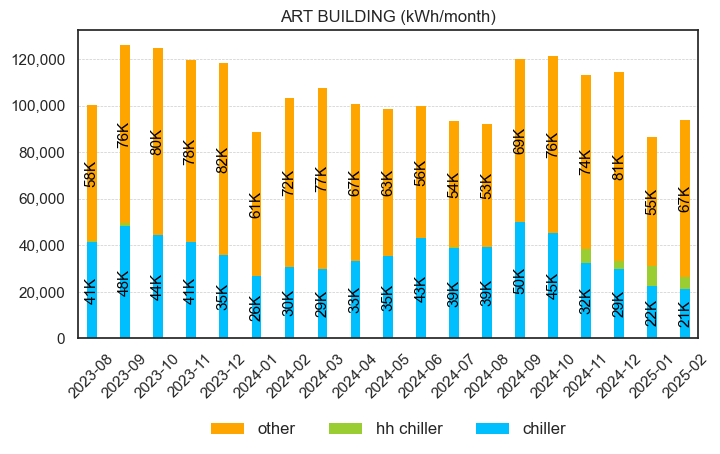

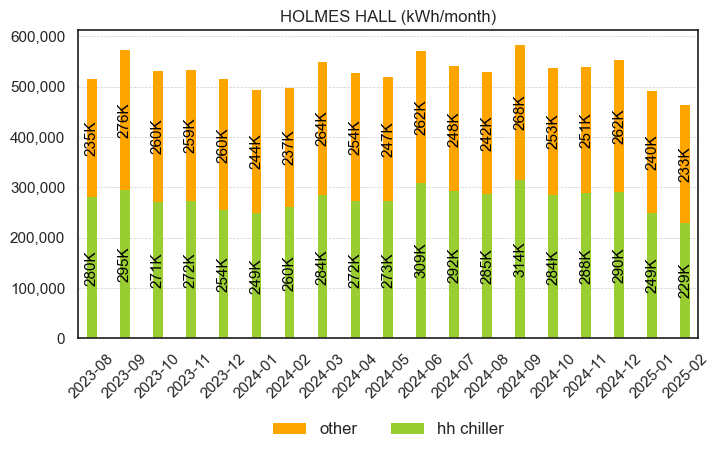

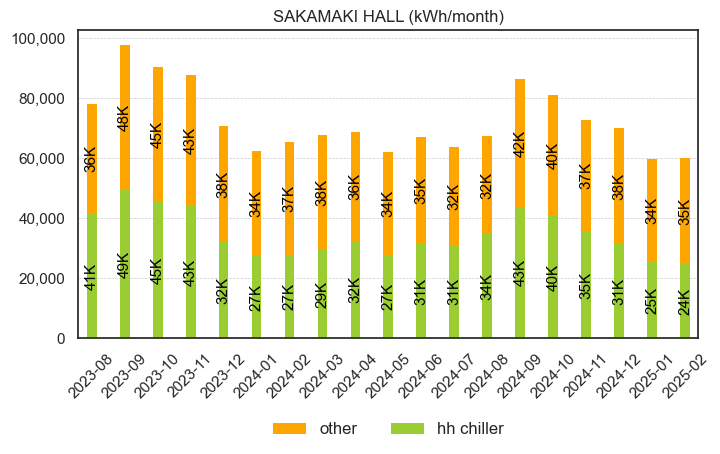

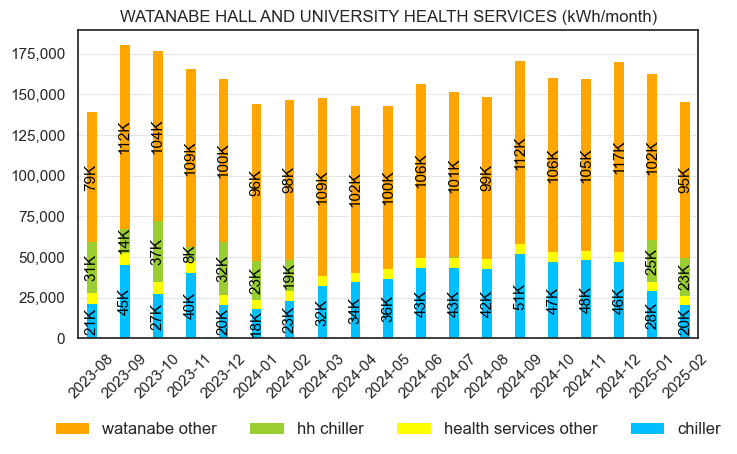

In [7]:
# Plot settings
plt.figure(figsize=(8, 4))
sns.set(style='white')

# Define correct colors based on provided legend image
color_map = {
    'chiller': 'deepskyblue', 
    'hh chiller': 'yellowgreen', 
    'health services other': 'yellow', 
    'watanabe other': 'orange',
    'other': 'orange'  
}

# Function to format y-axis labels with commas and convert to 'K' format
formatter = ticker.FuncFormatter(lambda x, _: f'{int(x/1000):,}K')

# Plot for each building
for building in energy_agg['building_complex_name'].unique():
    building_data = energy_agg[energy_agg['building_complex_name'] == building]
    building_pivot = building_data.pivot(index='bill_month', columns='end_use', values='kwh')
    
    available_end_uses = building_pivot.columns
    colors = [color_map[end_use] for end_use in available_end_uses if end_use in color_map]
    
    ax = building_pivot.plot(
        kind='bar', stacked=True, figsize=(8, 4), width=0.3, color=colors, edgecolor='none'
    )
    
    plt.title(f'{building} (kWh/month)', fontsize=12)
    plt.xlabel('', fontsize=11)
    # plt.ylabel('kWh', fontsize=11)
    plt.xticks(rotation=45, fontsize=11)
    plt.yticks(fontsize=11)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
    
    ax.grid(axis='y', linestyle='--', linewidth=0.5)
    ax.grid(axis='x', linestyle='')  # Remove vertical grid lines
        
    for container, end_use in zip(ax.containers, available_end_uses):
        if end_use != 'health services other':
            if building != energy_agg['building_complex_name'].unique()[0] or end_use != 'hh chiller':
                labels = [f'{int(v/1000):,}K' if int(v/1000) > 0 else '' for v in container.datavalues]
                for rect, label in zip(container, labels):
                    height = rect.get_y() + rect.get_height() / 2  # Position text in the middle of the bar
                    ax.text(rect.get_x() + rect.get_width() / 2, height, label,
                        ha='center', va='center', fontsize=11, color='black', rotation=90)                
  
    # Only include legend items that exist in this building's data, reversed for opposite listing
    handles, labels = ax.get_legend_handles_labels()
    new_handles, new_labels = zip(*reversed(list(zip(handles, labels))))
    plt.legend(new_handles, new_labels, loc='lower center', bbox_to_anchor=(0.5, -0.37), fontsize=12, ncol=len(new_labels), frameon=False)
    
    # Ensure the 'monthly' folder inside plot_dir exists
    monthly_dir = os.path.join(plot_dir, 'monthly')
    os.makedirs(monthly_dir, exist_ok=True)

    # Save the plot
    plt.savefig(f"{monthly_dir}/{building.replace(' ', '_')}.pdf", bbox_inches='tight')